#Imports

In [1]:
!pip install ucimlrepo

In [2]:
#pip install ucimlrepo
import pandas as pd
import numpy as np
from ucimlrepo import fetch_ucirepo
import os

import matplotlib.pyplot as plt
from collections import Counter
import sklearn
import sklearn.cluster
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn import clone
from sklearn.exceptions import NotFittedError
from tqdm import tqdm
from sklearn.datasets import fetch_openml

In [3]:
#remove warning about future changes
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

#Data preprocessing

In [4]:
#this cell needs internet to download the adult dataset.
#Otherwise the markdown cell below can be executed if the files have been downloaded and are stored on your computer
adult = fetch_ucirepo(id=2)
X = adult.data.features
X['predic']= adult.data.targets

data=open(r'adult\adult.data', 'r').read()
test=data.split('\n')
for i in range(len(test)):
    test[i]=test[i].split(',')
test=test[:-2]
nom_col=['age','workclass','fnlwgt','education','education_num', 'marital-status','occupation','relationship',
         'race','sex', 'capital-gain','capital-loss','hours-per-week', 'native-country', 'predic']
X=pd.DataFrame(test, columns=nom_col)
for i in nom_col:
    X[i] = X[i].str.replace(' ', '',regex=False)
passage_int=['age', 'fnlwgt', 'education_num', 'capital-gain','capital-loss','hours-per-week']
X[passage_int]=X[passage_int].astype(int)
X['sex'] = X['sex'].str.replace(' ', '',regex=False)
X['predic'] = X['predic'].str.replace(' ', '',regex=False)

In [5]:
#technical cell, to remove few problems in text cells, and to delete the entries having non defined elements
X = X.rename(columns=lambda x: x.replace('-', '_'))
X['predic'] = X['predic'].str.replace('.', '',regex=False)
X = X.dropna()
X = X.reset_index(drop=True)

In [6]:
#creates a new database starting from adult : categorical variables are transformed into dummy variables (one column is created for each class, having one for the element belonging to this class)
#the database is normalised

X_bis = X.copy()
X_bis['capital'] = X_bis['capital_gain']-X_bis['capital_loss']
X_bis = X_bis.drop(columns=['education','capital_gain','capital_loss'])
X_bis['sex'] = X_bis['sex'].map({'Male': 1, 'Female': 0})
X_bis['predic'] = X_bis['predic'].map({'>50K': 1, '<=50K': 0})
df_onehot = pd.get_dummies(X_bis[['workclass', 'marital_status', 'occupation', 'relationship','relationship','race','native_country']], drop_first=True)
scaler = StandardScaler()
X_bis['age'] = scaler.fit_transform(X_bis['age'].values.reshape(-1, 1)).copy()
X_bis['fnlwgt'] = scaler.fit_transform(X_bis['fnlwgt'].values.reshape(-1, 1)).copy()
X_bis['hours_per_week'] = scaler.fit_transform(X_bis['hours_per_week'].values.reshape(-1, 1)).copy()
X_bis['education_num'] = scaler.fit_transform(X_bis['education_num'].values.reshape(-1, 1)).copy()
X_bis['capital'] = scaler.fit_transform(X_bis['capital'].values.reshape(-1, 1)).copy()
data_processed = pd.concat([X_bis, df_onehot], axis=1)
data_processed = data_processed.drop(columns=['workclass', 'marital_status', 'occupation', 'relationship','relationship','race','native_country'])

In [7]:
#Création of the features database and the answer database
X_processed = data_processed.copy()
y_processed = X_processed['predic']
X_processed = X_processed.drop(columns=['predic'])

In [11]:
list(set(y_processed))
list()

[]

In [38]:
y_processed

0        0
1        0
2        0
3        0
4        0
        ..
47616    0
47617    0
47618    0
47619    0
47620    1
Name: predic, Length: 47621, dtype: int64

In [41]:
X_processed.to_csv('X_adult.csv', index=False)
y_test = pd.read_csv('y_adult.csv')['predic']
list(set(y_test))

[0, 1]

In [40]:
y_test

0        0
1        0
2        0
3        0
4        0
        ..
47616    0
47617    0
47618    0
47619    0
47620    1
Name: predic, Length: 47621, dtype: int64

#Algorithm

This section corresponds to the algorithm presented in the paper. It is made of
* a cell encoding the class ShadowModel. A shadow model is trained on given data, and creates a database made of data (data that was in the train set and data that was not) along with the answers (in probabilites) of this model.
* a cell encoding the class ShadowModels. This class is going to create list of shadow models, and concatenate the databases they create.
* a cell encoding the class HackingModel. This class uses the previous datasets, and trains a hacking algorithm for each value y possible.

## Code

In [8]:
#This class describes only one shadow model
class  ShadowModel:
    #takes a sklearn model, and datasets for training and testing
    #list_y_class is the list of values that y can take
    def __init__(self, model, X_train, X_test, y_train, y_test, liste_y_class):
        self.model = model
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.liste_y_class = liste_y_class
        self.model_fit(X_train, y_train)
        self.model_pred_proba()

    #fit self.model according to X and y
    def model_fit(self,X,y):
        self.X_train = X
        self.y_train = y
        self.model.fit(X, y)

    #this function creates the database we will use for the hack model
    #to every line of X, we have to add the prediction probabilities, and if wether or not it was in the training set
    #this cell is a bit technical, because all the elements available in y might not match all the possible values of y
    def model_pred_proba(self):
        #results for the train set
        predictions_df_temp = pd.DataFrame(self.model.predict_proba(self.X_train), columns=list(set(self.y_train))).reset_index(drop=True)
        predictions_df = pd.DataFrame([[0]*len(self.liste_y_class) for i in range(len(predictions_df_temp))], columns=self.liste_y_class)
        predictions_df[predictions_df_temp.columns]= predictions_df_temp

        X_train_proba = pd.concat([self.X_train.reset_index(drop=True), predictions_df.reset_index(drop=True)],  axis=1)
        X_train_proba['predic'] = self.y_train.reset_index(drop=True)
        X_train_proba['entrainement'] = 1 #indicates that these elements where in the train set

        #results for the test set
        predictions_df_temp2 = pd.DataFrame(self.model.predict_proba(self.X_test), columns=list(set(self.y_train))).reset_index(drop=True)
        predictions_df2 = pd.DataFrame([[0]*len(self.liste_y_class) for i in range(len(predictions_df_temp2))], columns=self.liste_y_class)
        predictions_df2[predictions_df_temp2.columns]= predictions_df_temp2
        X_test_proba = pd.concat([self.X_test.reset_index(drop=True), predictions_df2.reset_index(drop=True)],  axis=1)
        X_test_proba['predic'] = self.y_test.reset_index(drop=True)
        X_test_proba['entrainement'] = 0 #indicates that these elements where in the test set

        self.X_proba = pd.concat([X_train_proba,X_test_proba])


In [9]:
#this class creates all the shadow models we are going to use. Hence it contains multiple shadow models.
class ShadowModels:
    #list_y_class contains all the values that y can take
    def __init__(self, models, X, y,list_y_class):
        self.X = X
        self.y = y
        self.list_y_class = list_y_class
        self.fit_models(models, list_y_class)
        self.concatenate_data()

    #this functions create a shadow model for every element of the list models
    #modelsis a list of sklearn models. Dataset are equally split into dataset and training set
    def fit_models(self, models,list_y_class):
        n = len(self.X)//2
        self.shadow_models = []
        for model in models:
            X_train, X_test, y_train, y_test=train_test_split(self.X, self.y, test_size = n, train_size= n,stratify = self.y)
            self.shadow_models.append(ShadowModel(model, X_train, X_test, y_train, y_test,list_y_class))

    #this function concatenates all the databases created by the shadow models, in order to create a dataframe for the hacking model
    def concatenate_data(self):
        data_attaquant= self.shadow_models[0].X_proba
        for shadow_model in self.shadow_models[1:]:
            data_attaquant = pd.concat([data_attaquant, shadow_model.X_proba],ignore_index=True ,axis=0)
        self.data_attaquant = data_attaquant

In [10]:
#this class trains the hacking model
class HackingModel:

    #entries : hack_model (sklearn model, the one we will train and will perform hacking), shadow_models (list of sklearn models that we will use as shadow models),
    #list_y_class (all the values y can take), list_y_target_model (all the y values that were in the dataset used by the target model)
    def __init__(self, hack_model, shadow_models, X, y, list_y_class,list_y_target_model):
        self.X = X
        self.y = y
        self.list_y_class = list_y_class
        self.list_y_target_model = list_y_target_model
        #creation of an object ShadowModels that contains all the ShadowModel we will use for hacking
        self.shadowmodels = ShadowModels(shadow_models, X, y, list_y_class)
        self.hack_models = {}
        #we create a hack_model for each class of y
        for class_y in self.list_y_class:
            self.hack_models[class_y] = clone(hack_model)

        self.set_data_per_class()
        self.fit_hack_models()

    #creates a list of datasets, corresponding to each value that y can take
    def set_data_per_class(self):
        self.list_entrainement = []
        for class_y in self.list_y_class:
            y = self.shadowmodels.data_attaquant[self.shadowmodels.data_attaquant['predic']==class_y].entrainement
            X = self.shadowmodels.data_attaquant[self.shadowmodels.data_attaquant['predic']==class_y].drop(columns=['entrainement'])
            X.columns = X.columns.astype(str)
            self.list_entrainement.append([X,y])

    #this function fits all the hack models (that is to say for every value of y)
    def fit_hack_models(self):
        for (datas, class_y) in tqdm(zip(self.list_entrainement, self.list_y_class)):
            if len(datas[0])>0:
                self.hack_models[class_y].fit(datas[0], datas[1])

    #this function predicts for every x in X if the model was trained on it or not.
    #For every value of y, we use the appropriated hack model
    def predict(self, X):
        predictions = []
        for class_y in self.list_y_class:
            X_class_y = X[X['predic']==class_y]
            index = X_class_y.index
            if len(X_class_y)>0:
                #predictions.append(pd.DataFrame(self.hack_models[class_y].predict(X_class_y), index=index))
                try:
                    predictions.append(pd.DataFrame(self.hack_models[class_y].predict(X_class_y), index=index))
                except NotFittedError as e:
                    predictions.append(pd.DataFrame([0]*len(X_class_y), index=index))

        return pd.concat(predictions,axis=0)

    #this function, given X and y, predicts which elements were in the dataset or not.
    #target model is the model we want to hack
    def predict_target_model(self, X, y, target_model):
        prob = target_model.predict_proba(X)
        prob = pd.DataFrame(prob, columns=self.list_y_target_model).reset_index(drop=True)
        prob_p = pd.DataFrame([[0]*len(self.list_y_class) for i in range(len(prob))], columns=self.list_y_class)
        prob_p[prob.columns] = prob

        X = pd.concat([X.reset_index(drop=True), prob_p.reset_index(drop=True)],  axis=1)
        X['predic'] = y.reset_index(drop=True)
        X.columns = X.columns.astype(str)
        return self.predict(X)


    #this function gives the classification report of the model
    #X_in and y_in were in the training dataset of the target model, X_out and y_out were not
    def print_score_hacking(self, X_in, y_in, X_out, y_out, target_model):
      res_in = self.predict_target_model(X_in, y_in, target_model)[0]
      res_out = self.predict_target_model(X_out, y_out, target_model)[0]
      res = np.concatenate((res_in.values,res_out.values))
      true_values = [1]*len(res_in) + [0]*len(res_out)

      report = classification_report(true_values, res)
      print("Classification Report, test set:")
      print(report)

    def give_constants(self, X_in, y_in, X_out, y_out, target_model):
      res_in = self.predict_target_model(X_in, y_in, target_model)[0]
      res_out = self.predict_target_model(X_out, y_out, target_model)[0]
      res = np.concatenate((res_in.values,res_out.values))
      true_values = [1]*len(res_in) + [0]*len(res_out)

      report = classification_report(true_values, res,output_dict = True)
      return report['accuracy'],report['weighted avg']['f1-score']


## Test

In [11]:
#Target model
X_train, X_test, y_train, y_test = train_test_split(X_processed, y_processed, test_size=1000, train_size=1000,stratify = y_processed)
logistic_clf = LogisticRegression(C= 100)
logistic_clf.fit(X_train, y_train)

C:\Users\guspo\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=100)

In [12]:
#on split les données en deux, on garde le set shadow qui va servir à entrainer les shadow models
X_shadow, temp, y_shadow, temp2 = train_test_split(X_processed, y_processed, test_size=10000, train_size=10000,stratify = y_processed)

In [13]:
models = [LogisticRegression(C=100)]*10
test = HackingModel(RandomForestClassifier(n_estimators=1000),models, X_shadow, y_shadow,
                  list(set(y_shadow)),list(set(y_train)) )
test.print_score_hacking(X_train,y_train, X_test,y_test, logistic_clf)

C:\Users\guspo\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\guspo\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Classification Report, test set:
              precision    recall  f1-score   support

           0       0.50      0.49      0.49      1000
           1       0.50      0.51      0.50      1000

    accuracy                           0.50      2000
   macro avg       0.50      0.50      0.50      2000
weighted avg       0.50      0.50      0.50      2000



In [ ]:
#Target model
X_train, X_test, y_train, y_test = train_test_split(X_processed, y_processed, test_size=1000, train_size=1000,stratify = y_processed)
MLPC_clf = MLPClassifier(random_state=1, max_iter=300)
MLPC_clf.fit(X_train, y_train)

In [ ]:
models = [MLPClassifier(random_state=1, max_iter=300) for i in range(10)]
test = HackingModel(RandomForestClassifier(n_estimators=1000),models, X_shadow, y_shadow,
                  list(set(y_shadow)),list(set(y_train)) )
test.print_score_hacking(X_train,y_train, X_test,y_test, logistic_clf)

C:\Users\guspo\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\guspo\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\guspo\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\guspo\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\guspo\anaconda3\lib\site-packages\sklearn\neural_network\_multi

# Tests des modèles sur les données - a supprimer ?

In [ ]:
#permet de calculer l'accuracy d'un modèle sur le set d'entrainement et sur un set de test
def print_score(clf, X_train, y_train, X_test, y_test, train=True):
    if train:
        pred = clf.predict(X_train)
        clf_report = pd.DataFrame(classification_report(y_train, pred, output_dict=True))
        print(f"Train Result ; Accuracy Score: {accuracy_score(y_train, pred) * 100:.2f}%")


    elif train==False:
        pred = clf.predict(X_test)
        clf_report = pd.DataFrame(classification_report(y_test, pred, output_dict=True))
        print(f"Test Result ; Accuracy Score: {accuracy_score(y_test, pred) * 100:.2f}%")

In [ ]:
#modèle de classification avec Knn
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_train)

#print_score(knn_clf, X_train, y_train, X_test, y_test, train=True)
#print_score(knn_clf, X_train, y_train, X_test, y_test, train=False)

y_pred = knn_clf.predict(X_test)
b = classification_report(y_pred,y_test)

a = classification_report(y_pred,y_test,output_dict = True)
print(b)
print(a['weighted avg']['precision'])

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       1.00      0.64      0.78        36
           2       0.70      1.00      0.82        14
           3       0.90      0.75      0.82        24
           4       0.86      0.82      0.84        22
           5       0.53      0.90      0.67        10
           6       0.85      0.94      0.89        18
           7       0.82      0.72      0.77        25
           8       0.67      1.00      0.80        12
           9       0.75      0.75      0.75        20

    accuracy                           0.81       200
   macro avg       0.81      0.85      0.81       200
weighted avg       0.85      0.81      0.82       200

0.8465290297937358


In [ ]:
#modèle de classification par régression logistique
logistic_clf = LogisticRegression(C=30.0)
logistic_clf.fit(X_train, y_train)

print_score(logistic_clf, X_train, y_train, X_test, y_test, train=True)
print_score(logistic_clf, X_train, y_train, X_test, y_test, train=False)

Train Result ; Accuracy Score: 90.00%
Test Result ; Accuracy Score: 81.00%


In [ ]:
#modèles de classification avec un arbre de décision simple
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)

print_score(tree_clf, X_train, y_train, X_test, y_test, train=True)
print_score(tree_clf, X_train, y_train, X_test, y_test, train=False)

Train Result ; Accuracy Score: 100.00%
Test Result ; Accuracy Score: 72.00%


In [ ]:
#modèles de classification avec la méthode random forest
rf_clf = RandomForestClassifier(n_estimators=1000, random_state=42)
rf_clf.fit(X_train, y_train)

print_score(rf_clf, X_train, y_train, X_test, y_test, train=True)
print_score(rf_clf, X_train, y_train, X_test, y_test, train=False)

Train Result ; Accuracy Score: 100.00%
Test Result ; Accuracy Score: 83.00%


## Shadow Model

## Model de Hack

# MNIST

In [ ]:
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, parser='auto')
X = X.values
y = y.astype(int).values
X = (X/255. - .5)*2

In [ ]:
print(X.shape)

(70000, 784)


In [ ]:
mnist = fetch_openml(name='mnist_784', version=1)
mnist_df = pd.DataFrame(data=mnist.data, columns=mnist.feature_names)
mnist_df['target'] = mnist.target.astype(int)

In [ ]:
X_processed = mnist_df.drop(columns=['target']).head(5000)
y_processed = mnist_df['target'].head(5000)

In [ ]:
#Target model
X_train, X_test, y_train, y_test = train_test_split(X_processed, y_processed, test_size=200, train_size=200,stratify = y_processed)
logistic_clf = RandomForestClassifier()
logistic_clf.fit(X_train, y_train)

RandomForestClassifier()

In [ ]:
#on split les données en deux, on garde le set shadow qui va servir à entrainer les shadow models
X_shadow, temp, y_shadow, temp2 = train_test_split(X_processed, y_processed, test_size=2500, train_size=2500,stratify = y_processed)

In [ ]:
models = [RandomForestClassifier()]*20
test = HackingModel(RandomForestClassifier(n_estimators=200),models, X_shadow, y_shadow,
                  list(set(y_shadow)),list(set(y_train)) )
test.print_score_hacking(X_train,y_train, X_test,y_test, logistic_clf)

10it [01:20,  8.00s/it]


Classification Report, test set:
              precision    recall  f1-score   support

           0       0.71      1.00      0.83       200
           1       1.00      0.59      0.75       200

    accuracy                           0.80       400
   macro avg       0.86      0.80      0.79       400
weighted avg       0.86      0.80      0.79       400



In [ ]:
n_shadow_models = [5,10,15,20]

list_accuracy = []
list_f1score = []

for i in range(len(n_shadow_models)):
  #target model
  X_train, X_test, y_train, y_test = train_test_split(X_processed, y_processed, test_size=200, train_size=200,stratify = y_processed)
  target_model = RandomForestClassifier()
  target_model.fit(X_train, y_train)

  #shadow model and hacking model
  X_shadow, temp, y_shadow, temp2 = train_test_split(X_processed, y_processed, test_size=2500, train_size=2500,stratify = y_processed)
  models = [RandomForestClassifier()]*n_shadow_models[i]
  hack = HackingModel(RandomForestClassifier(n_estimators=200),models, X_shadow, y_shadow,
                    list(set(y_shadow)),list(set(y_train)) )
  a,b = hack.give_constants(X_train,y_train, X_test,y_test, target_model)

  list_accuracy.append(a)
  list_f1score.append(b)


10it [00:17,  1.73s/it]
10it [00:30,  3.09s/it]
10it [00:41,  4.18s/it]
10it [00:54,  5.49s/it]


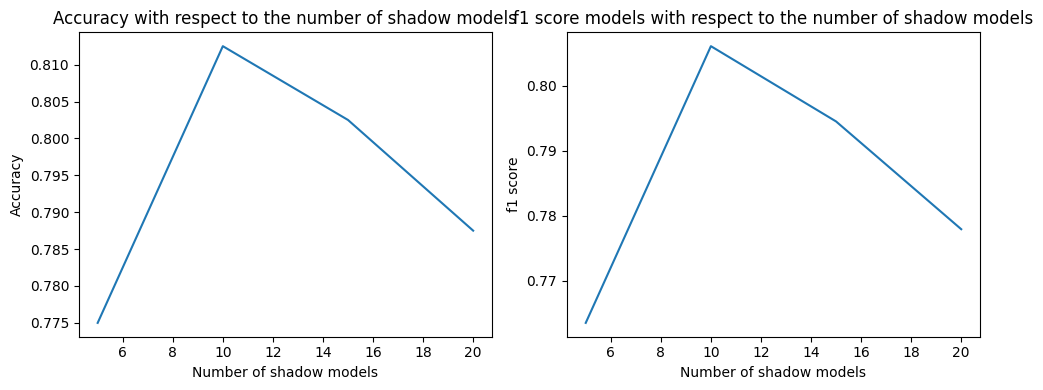

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

axs[0].plot(n_shadow_models, list_accuracy)
axs[0].set_xlabel('Number of shadow models')
axs[0].set_title("Accuracy with respect to the number of shadow models")
axs[0].set_ylabel("Accuracy")

axs[1].plot(n_shadow_models, list_f1score)
axs[1].set_xlabel('Number of shadow models')
axs[1].set_title("f1 score models with respect to the number of shadow models")
axs[1].set_ylabel("f1 score")

plt.tight_layout()
plt.show()


In [ ]:
list_C = [5,10,15,20]

n_shadow_models = 10
list_accuracy = []
list_f1score = []

for i in range(len(list_C)):
  #target model
  X_train, X_test, y_train, y_test = train_test_split(X_processed, y_processed, test_size=200, train_size=200,stratify = y_processed)
  target_model = LogisticRegression(C = list_C[i])
  target_model.fit(X_train, y_train)

  #shadow model and hacking model
  X_shadow, temp, y_shadow, temp2 = train_test_split(X_processed, y_processed, test_size=2500, train_size=2500,stratify = y_processed)
  models = [ LogisticRegression(C = list_C[i])]*n_shadow_models
  hack = HackingModel(RandomForestClassifier(n_estimators=200),models, X_shadow, y_shadow,
                    list(set(y_shadow)),list(set(y_train)) )
  a,b = hack.give_constants(X_train,y_train, X_test,y_test, target_model)

  list_accuracy.append(a)
  list_f1score.append(b)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

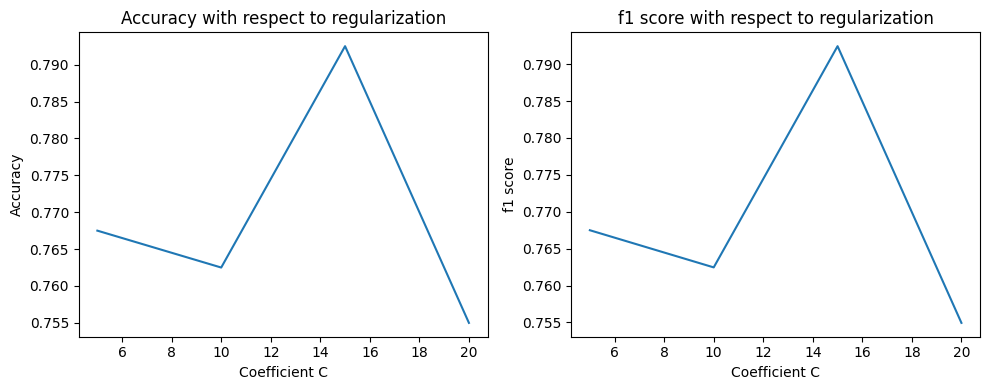

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

axs[0].plot(list_C, list_accuracy)
axs[0].set_xlabel('Coefficient C')
axs[0].set_title("Accuracy with respect to regularization")
axs[0].set_ylabel("Accuracy")

axs[1].plot(list_C, list_f1score)
axs[1].set_xlabel('Coefficient C')
axs[1].set_title("f1 score with respect to regularization")
axs[1].set_ylabel("f1 score")

plt.tight_layout()
plt.show()


In [ ]:
list_C = [5,10,15,20]

n_shadow_models = 10
list_accuracy = []
list_f1score = []

for i in range(len(list_C)):
  #target model
  X_train, X_test, y_train, y_test = train_test_split(X_processed, y_processed, test_size=200, train_size=200,stratify = y_processed)
  target_model = LogisticRegression(C = list_C[i])
  target_model.fit(X_train, y_train)

  #shadow model and hacking model
  X_shadow, temp, y_shadow, temp2 = train_test_split(X_processed, y_processed, test_size=2500, train_size=2500,stratify = y_processed)
  models = [ LogisticRegression(C = list_C[i])]*n_shadow_models
  hack = HackingModel(RandomForestClassifier(n_estimators=200),models, X_shadow, y_shadow,
                    list(set(y_shadow)),list(set(y_train)) )
  a,b = hack.give_constants(X_train,y_train, X_test,y_test, target_model)

  list_accuracy.append(a)
  list_f1score.append(b)


10it [00:39,  3.98s/it]
10it [01:10,  7.10s/it]
10it [01:30,  9.09s/it]
10it [01:34,  9.45s/it]


# Synthetic dataset

In [ ]:
#warnings.filterwarnings("ignore")

In [ ]:
data_synt=pd.DataFrame(np.random.normal(loc=0, scale=1, size=(10000, 10)))
data_synt['A']= (data_synt[1] + data_synt[0] > 4).astype(int)
data_synt['B']= (data_synt[2] - 3*data_synt[3] + data_synt[4] > 0).astype(int)
data_synt['C']= (data_synt[5] - 3*data_synt[6] + data_synt[7] > 3).astype(int)
data_synt['D']= (-data_synt[8] - data_synt[9]  > 0).astype(int)
classification_y=['A','B','C','D']
data_synt['E']=0
for i in range(len(classification_y)):
    col=classification_y[i]
    data_synt['E']+=2**i * data_synt[col]
X_synt=data_synt.copy()
X_synt=X_synt.drop(columns=['A','B','C','D','E'])
y_synt=data_synt.copy()
y_synt=y_synt.drop(columns=[i for i in range(10)])
y_synt=y_synt.drop(columns=['A','B','C','D'])

In [ ]:
#Modèle à hacker
X_train, X_test, y_train, y_test = train_test_split(X_synt, y_synt, test_size=1000, train_size=300)
liste_y_target_model=list(set(y_train.E))
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_train)

print_score(knn_clf, X_train, y_train, X_test, y_test, train=True)
print_score(knn_clf, X_train, y_train, X_test, y_test, train=False)

Train Result ; Accuracy Score: 70.00%
Test Result ; Accuracy Score: 57.50%


In [ ]:
models = [KNeighborsClassifier() for i in range(20)]
test=HackingModel(RandomForestClassifier(n_estimators=1000),models, X_synt, y_synt['E'], list(set(y_synt['E'])), liste_y_target_model)
test.score_hacking(X_train,y_train['E'], X_test,y_test['E'], knn_clf)

recall : 0.6466666666666666
precision : 0.26944444444444443
